In [2]:
!pip install timm
!pip install mlflow
!pip install einops
!pip install --upgrade huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached timm-0.9.2-py3-none-any.whl (2.2 MB)
  Using cached safetensors-0.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
import timm
import random
import matplotlib.ticker as ticker
import torch.nn.functional as F
import json
import torchvision

from tqdm import tqdm, trange
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

In [6]:
train_dir = Path("/content/drive/MyDrive/Colab Notebooks/aihub-meat-image/Training")

########## IMAGE ########

image_dirs = [
    train_dir / "[image]cow_seg_1",
    train_dir / "[image]cow_seg_2",
    train_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

data = pd.DataFrame(filepaths, columns=['Filepath'])

data['Grade'] = [Path(filepath).stem.split('_')[-2] for filepath in data['Filepath']]
data['Grade'] = data['Grade'].apply(int)-1

train_data = data
print(train_data)


                                               Filepath  Grade
0     /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
1     /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
2     /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
3     /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
4     /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
...                                                 ...    ...
2995  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
2996  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
2997  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
2998  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
2999  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2

[3000 rows x 2 columns]


In [34]:
valid_dir = Path("/content/drive/MyDrive/Colab Notebooks/aihub-meat-image/Validation")
########## IMAGE ########
image_dirs = [
    valid_dir / "[image]cow_seg_1",
    valid_dir / "[image]cow_seg_2",
    valid_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

valid_data = pd.DataFrame(filepaths, columns=['Filepath'])

valid_data['Grade'] = [Path(filepath).stem.split('_')[-2] for filepath in valid_data['Filepath']]
valid_data['Grade'] = valid_data['Grade'].apply(int) - 1

# Select 100 samples from each grade
selected_samples = []
for grade in range(3):
    grade_samples = valid_data[valid_data['Grade'] == grade].sample(n=100, random_state=42)
    selected_samples.append(grade_samples)

valid_data = pd.concat(selected_samples).reset_index(drop=True)

print(valid_data)

test_data = valid_data


                                              Filepath  Grade
0    /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
1    /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
2    /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
3    /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
4    /content/drive/MyDrive/Colab Notebooks/aihub-m...      0
..                                                 ...    ...
295  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
296  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
297  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
298  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2
299  /content/drive/MyDrive/Colab Notebooks/aihub-m...      2

[300 rows x 2 columns]


In [35]:
class CreateImageDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data
        self.transform = transform


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data['Filepath'].iloc[idx]
        label = self.data['Grade'].iloc[idx]

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        return image, label

transformation = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.RandomGrayscale(),
    transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
    transforms.ToTensor(),
    ])
valid_transformation = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    ])


In [36]:
#Define hyperparameters
batch_size = 64
lr = 1e-5
epochs = 20

In [37]:
train_data.reset_index(drop=True, inplace=True)  # Reset the index of the train_data DataFrame
test_data.reset_index(drop=True, inplace=True)  # Reset the index of the test_data DataFrame
train_dataset = CreateImageDataset(train_data, transform=transformation)
valid_dataset = CreateImageDataset(test_data, transform=valid_transformation)

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers = 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [39]:
import mlflow

cuda
Epoch 1/20


100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


1e-05
The Validation Loss is 0.535784924030304 and the validation accuracy is 0.7534090909090909
The Training Loss is 0.47086431117767985 and the training accuracy is 0.7898936170212766
Epoch 2/20


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


1e-05
The Validation Loss is 0.5068750739097595 and the validation accuracy is 0.7517045454545455
The Training Loss is 0.46820863257063194 and the training accuracy is 0.7958301671732522
Epoch 3/20


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


1e-05
The Validation Loss is 0.49470213055610657 and the validation accuracy is 0.7693181818181818
The Training Loss is 0.45499316428570036 and the training accuracy is 0.7999620060790273
Epoch 4/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.4880251348018646 and the validation accuracy is 0.7616477272727272
The Training Loss is 0.43214023176659927 and the training accuracy is 0.8103628419452887
Epoch 5/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.5050232410430908 and the validation accuracy is 0.7676136363636363
The Training Loss is 0.4147362988045875 and the training accuracy is 0.8170592705167173
Epoch 6/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.4815468966960907 and the validation accuracy is 0.765625
The Training Loss is 0.4144445562616308 and the training accuracy is 0.8285049392097265
Epoch 7/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.48585633039474485 and the validation accuracy is 0.7642045454545455
The Training Loss is 0.3984452251424181 and the training accuracy is 0.8256553951367781
Epoch 8/20


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


1e-05
The Validation Loss is 0.4811337530612946 and the validation accuracy is 0.7752840909090909
The Training Loss is 0.38386296560155586 and the training accuracy is 0.8333016717325228
Epoch 9/20


100%|██████████| 47/47 [00:32<00:00,  1.44it/s]


1e-05
The Validation Loss is 0.4785031497478485 and the validation accuracy is 0.7625
The Training Loss is 0.366369144079533 and the training accuracy is 0.8407104863221884
Epoch 10/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.4738909900188446 and the validation accuracy is 0.759090909090909
The Training Loss is 0.355973093750629 and the training accuracy is 0.8506363981762918
Epoch 11/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.4819455504417419 and the validation accuracy is 0.7673295454545455
The Training Loss is 0.3380360952083101 and the training accuracy is 0.8543408054711246
Epoch 12/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.4770377933979034 and the validation accuracy is 0.76875
The Training Loss is 0.33122182019213414 and the training accuracy is 0.862082066869301
Epoch 13/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.4651667416095734 and the validation accuracy is 0.76875
The Training Loss is 0.32203865114678726 and the training accuracy is 0.8670687689969605
Epoch 14/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.45412578582763674 and the validation accuracy is 0.7730113636363637
The Training Loss is 0.30408670642274493 and the training accuracy is 0.868636018237082
Epoch 15/20


100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


1e-05
The Validation Loss is 0.47413102984428407 and the validation accuracy is 0.7661931818181819
The Training Loss is 0.2930869460105896 and the training accuracy is 0.8806515957446809
Epoch 16/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1e-05
The Validation Loss is 0.4628019452095032 and the validation accuracy is 0.7795454545454545
The Training Loss is 0.29645921289920807 and the training accuracy is 0.8822188449848024
Epoch 17/20


100%|██████████| 47/47 [00:30<00:00,  1.52it/s]


1e-05
The Validation Loss is 0.47028560042381284 and the validation accuracy is 0.7673295454545455
The Training Loss is 0.27909413994626797 and the training accuracy is 0.8863031914893617
Epoch 18/20


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


1.0000000000000002e-06
The Validation Loss is 0.48237999677658083 and the validation accuracy is 0.7815340909090909
The Training Loss is 0.27705599082277177 and the training accuracy is 0.8848784194528876
Epoch 19/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1.0000000000000002e-06
The Validation Loss is 0.46521603465080263 and the validation accuracy is 0.790625
The Training Loss is 0.2504184876984738 and the training accuracy is 0.9030205167173252
Epoch 20/20


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


1.0000000000000002e-06
The Validation Loss is 0.47032874822616577 and the validation accuracy is 0.7855113636363636
The Training Loss is 0.25622059436554606 and the training accuracy is 0.8984137537993921


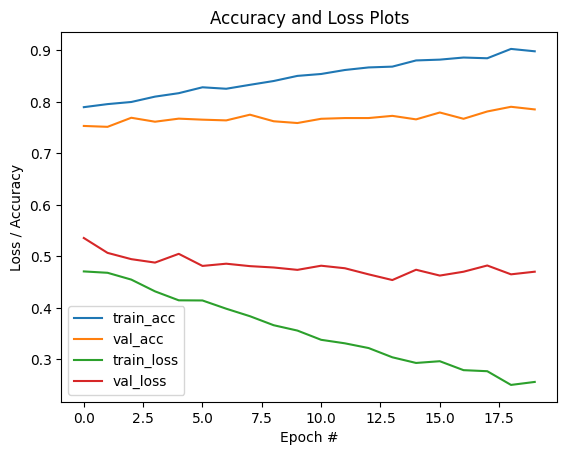

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 3)
torchvision.models.efficientnet_v2_s
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

# checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CNN-aihub/model_checkpoint.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor = 0.1, threshold = 0.005)
train_loss, val_loss, train_acc, val_acc =[], [], [], []
best_acc = 0
with mlflow.start_run() as run:
    mlflow.log_param("lr", lr)
    mlflow.log_param("epoch", epochs)
    mlflow.log_param("batch size", batch_size)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        #training
        model.train()
        total_loss, total_correct = 0,0
        for x, y in tqdm(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, preds = torch.max(output, 1)
            loss = criterion(output, y.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_correct += torch.sum(preds == y).item()/len(x)

        train_loss.append(total_loss/len(train_dataloader))
        train_acc.append(total_correct/len(train_dataloader))

        #validation
        model.eval()
        total_loss, total_correct = 0,0
        with torch.no_grad():
            for x, y in valid_dataloader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                _, preds = torch.max(output, 1)
                loss = criterion(output, y.long())
                optimizer.zero_grad()
                total_loss += loss.item()
                total_correct += torch.sum(preds == y).item()/len(x)
            val_loss.append(total_loss/len(valid_dataloader))
            val_acc.append(total_correct/len(valid_dataloader))
        scheduler.step(val_loss[-1])
        # Logging metrics with MLflow
        mlflow.log_metric("train_loss", train_loss[-1])
        mlflow.log_metric("train_acc", train_acc[-1])
        mlflow.log_metric("val_loss", val_loss[-1])
        mlflow.log_metric("val_acc", val_acc[-1])
        print(scheduler.optimizer.param_groups[0]['lr'])

        # saving best model
        if val_acc[-1]>best_acc:
            best_acc = val_acc[-1]
            torch.save({
                'epoch':epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss':val_loss[-1],
                'acc':val_acc[-1]
            }, 'model_checkpoint.pt')
        print('The Validation Loss is {} and the validation accuracy is {}'.format(val_loss[-1],val_acc[-1]))
        print('The Training Loss is {} and the training accuracy is {}'.format(train_loss[-1],train_acc[-1]))

# Plot the curves
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.title('Accuracy and Loss Plots')
plt.savefig("plot.png")
plt.show()

In [ ]:
print(scheduler.optimizer.param_groups['lr'])
